# Climate emulator

In [2]:
# Simple Climate and Sea Level Model (SCM-SLRM)

# Control parameters for the climate model
startyeartmp     = 1850
currentyear      = 2019
endyear          = 2100  # End year of simulation
OptimizeFeedback = false  # Determine the feedback factor Ff from the relation between dTs0 and observed temperatures
LandUseChange    = true  # Incorporate land use change in carbon emissions
NoFeedback       = false
OceanHeat        = true

# Control parameters for the sea level model
SeaLevel         = true
startyearsea     = 1880
ed               = 15  # embedding dimension (years) of SSAtrend smoother (15 was used in the paper)
la_iterate       = true  # iterate for lambda. No iteration -> estimate a only
bin              = 15
chao             = true  # use Chao reservoir corr

# Constants
boltzmann        = 5.67e-8  # Stefan-Boltzmann constant
albedo           = 0.3  # Planetary albedo
solar            = 1370  # Solar constant
CO2o             = 280  # Pre-industrial CO2 concentration
Cs               = 15  # characteristic time scale thermal inertia

# Feedbacks
Te               = (solar * (1 - albedo) / (4 * boltzmann))^0.25
La0              = -4 * boltzmann * Te^3  # Black body radiation feedback
LaW              = 1.6  # 1.6: water vapour feedback
LaL              = -0.6  # -0.6: Lapse rate feedback
LaC              = 0.3  # -0.4 - +1: Cloud feedback (uncertain)
LaA              = 0.3  # 0.3 % albedo feedback
LaUnc            = 0.5  # uncertainty on feedback parameters

if OceanHeat
    LaW          = 1.5  # 1.6: water vapour feedback
    LaL          = -0.4  # -0.6: longwave radiation feedback
    LaC          = 0.42  # -0.4 - +1: Cloud feedback (uncertain)
    LaA          = 0.35  # 0.3 % albedo feedback
    LaUnc        = 0.65  # uncertainty on feedback parameters
end


using Plots, Interpolations, DelimitedFiles, StatsBase, LsqFit
using Printf, LaTeXStrings, LinearAlgebra, DSP, Polynomials


# Function definitions
function CO2dQ(CO2, CO2o)
    return 5.35 * log.(CO2 ./ CO2o)
end

function load_data(filename)
    return readdlm(filename)
end

# Scenario selection
scenario_txt = ["Observed", "SSP1-19", "SSP1-26", "SSP2-45", "SSP3-70", "SSP5-85", "Constant", "T2xCO2"]
println("Future scenario:")
for (i, sc) in enumerate(scenario_txt)
    println("  ($(i-1)) $sc")
end
scenario = parse(Int, readline())

Lf = La0 + LaW + LaL + LaC + LaA
tau = OceanHeat ? -Cs / Lf : 0

if NoFeedback
    OptimizeFeedback = false
    LaW = 0
    LaL = 0
    LaC = 0
    LaA = 0
end

# Read input files
data = load_data("GreenhouseGases.txt")
year = collect(startyeartmp:1:currentyear)
x=data[:,1]
y=data[:,2]
CO2_interp = interpolate((x,), y, Gridded(Linear()))
CO2 = CO2_interp.(year)

data = load_data("BerkeleyTemps2021.txt")
x=data[:,1]
y=data[:,6]
tmp_interp = interpolate((x,), y, Gridded(Linear()))
tmp = tmp_interp.(year) .- mean(tmp_interp.(year[1:70]))
    
data = load_data("Emissions.txt")
x=data[:,1]
y = if LandUseChange
    data[:,2]
else
    data[:,4]
end
Em_interp=interpolate((x,), y / 1e9, Gridded(Linear()))
Em = Em_interp.(year)
Emtot = cumsum(Em)

# Fit between carbon emissions and CO2 concentrations
P = Polynomials.fit(Emtot[121:end], CO2[121:end], 1)

data = load_data("SSPscenarios.txt")
year2 = collect(currentyear:1:endyear)
data[1, 1] = currentyear
if endyear > 2100
    data[:, end+1] = data[:, end]
    data[1, end] = endyear
end
data[2:end, 1] .= Em[end] * 1e3
# Initialize the SSP array
SSP = zeros(length(year2), 5)
# Perform the interpolation and evaluation
for i in 1:5
    # Create interpolation function
    itp = interpolate((data[1, :],), data[i+1, :] / 1e3, Gridded(Linear()))
    # Evaluate interpolation at each point in year2
    SSP[:, i] = itp.(year2)
end

if scenario >= 7
    CO2[1:120] .= CO2o
    for i in 121:170
        CO2[i] = CO2[i-1] * 1.01
    end
end

# Radiative forcing
dQ = CO2dQ(CO2, CO2o)
dTs0 = -dQ / La0
if OptimizeFeedback
    # Perform a linear fit forced through (0,0)
    # Fit `y = a*x` by solving for 'a' directly using least squares.
    a = sum(dTs0 .* tmp) / sum(dTs0 .^ 2)
    # Create the polynomial model, which is simply P(x) = a*x
    Q = Polynomial([0, a])  # No constant term, just a linear term
    Ff = Q[1]
    FfUp = Ff + La0 / (Ff * La0 + LaUnc)
    FfLo = Ff - La0 / (Ff * La0 + LaUnc)
else
    Ff = 1 / (1 + LaL / La0 + LaW / La0 + LaC / La0 + LaA / La0)
    FfUp = 1 / (1 + LaL / La0 + LaW / La0 + LaC / La0 + LaA / La0 + LaUnc / La0)
    FfLo = 1 / (1 + LaL / La0 + LaW / La0 + LaC / La0 + LaA / La0 - LaUnc / La0)
end


dTs = Ff * dTs0
dTsUp = FfUp * dTs0
dTsLo = FfLo * dTs0

if tau > 0
    for i in 2:length(year)
        dTs[i] = (dTs[i-1] + dQ[i] / tau) / (1 - La0 / (tau * Ff))
        dTsUp[i] = (dTsUp[i-1] + dQ[i] / tau) / (1 - La0 / (tau * FfUp))
        dTsLo[i] = (dTsLo[i-1] + dQ[i] / tau) / (1 - La0 / (tau * FfLo))
    end
end

# Future simulations
if scenario == 0
    year2 = currentyear:(currentyear + 1)
    FutEm = fill(Em[end], length(year2))
elseif 1 <= scenario <= 5
    FutEm = SSP[:, scenario]
elseif scenario == 6 || scenario == 7
    FutEm = fill(Em[end], length(year2))
end

FutEmtot = zeros(length(FutEm)) .+ Emtot[end]
for i in 2:length(year2)
    FutEmtot[i] = FutEmtot[i-1] + FutEm[i]
end
FutCO2 = P.(FutEmtot)

if scenario == 7
    FutCO2[1] = CO2[end]
    for i in 2:length(FutCO2)
        FutCO2[i] = min(FutCO2[i-1] * 1.01, 2 * CO2o)
    end
end

FutdQ = CO2dQ(FutCO2, CO2o)
FutdTs = -Ff * FutdQ / La0
FutdTsUp = -FfUp * FutdQ / La0
FutdTsLo = -FfLo * FutdQ / La0

if tau > 0
    FutdTs[1] = dTs[end]
    FutdTsUp[1] = dTsUp[end]
    FutdTsLo[1] = dTsLo[end]
    for i in 2:length(year2)
        FutdTs[i] = (FutdTs[i-1] + FutdQ[i] / tau) / (1 - La0 / (tau * Ff))
        FutdTsUp[i] = (FutdTsUp[i-1] + FutdQ[i] / tau) / (1 - La0 / (tau * FfUp))
        FutdTsLo[i] = (FutdTsLo[i-1] + FutdQ[i] / tau) / (1 - La0 / (tau * FfLo))
    end
end


Future scenario:
  (0) Observed
  (1) SSP1-19
  (2) SSP1-26
  (3) SSP2-45
  (4) SSP3-70
  (5) SSP5-85
  (6) Constant
  (7) T2xCO2


stdin>  1


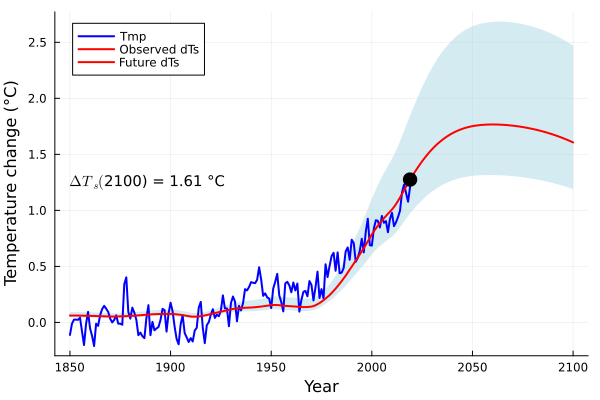

In [3]:
xh = vcat(year, reverse(year))
yh = vcat(dTsUp, reverse(dTsLo))
p1=plot(xh, yh, fillrange=0, fillcolor=:lightblue, fillalpha=0.5, linecolor=:transparent, linewidth=0,label="")
xh2 = vcat(year2, reverse(year2))
yh2 = vcat(FutdTsUp, reverse(FutdTsLo))
plot!(xh2, yh2, fillrange=0, fillcolor=:lightblue, fillalpha=0.5, linecolor=:transparent, linewidth=0, label="")
plot!(year, tmp, color=:blue, linewidth=2, label="Tmp")
plot!(year, dTs, color=:red, linewidth=2, label="Observed dTs")
plot!(year2, FutdTs, color=:red, linewidth=2, label="Future dTs")
scatter!([year[end]], [dTs[end]], color=:black, marker=:circle, markersize=8, markerstrokewidth=0, label="")
xlabel!("Year")
ylabel!("Temperature change (°C)")
txt = L"\Delta T_s (" * string(year2[end]) * ") = " * string(round(FutdTs[end], digits=2)) * " °C"
annotate!(1850, 1.25, text(txt, 10, :left))
display(p1)

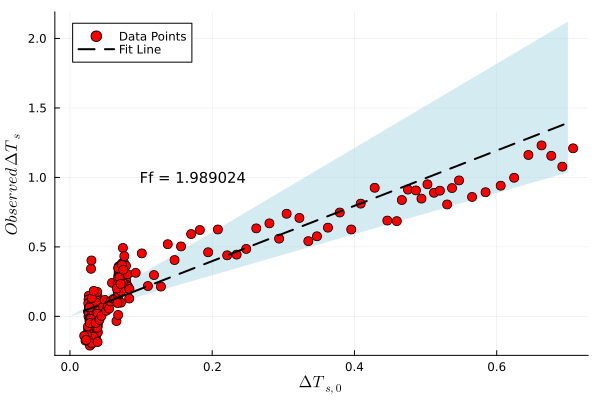

In [4]:
xh1 = collect(0:0.1:maximum(dTs0))
xh = vcat(xh1, reverse(xh1))
yh_upper = xh1 .* FfUp
yh_lower = xh1 .* FfLo
p2=plot(xh1, yh_upper, fillrange=yh_lower, fillcolor=:lightblue, linecolor=:transparent, fillalpha=0.5, label="")
scatter!(dTs0, tmp, color=:red, marker=:circle, markersize=5, label="Data Points")
plot!(dTs0, dTs0*Ff, color=:black, linewidth=2, linestyle=:dash, label="Fit Line")
txt = @sprintf("Ff = %.6f", Ff)
annotate!(0.1, 1, text(txt, 10, :left))
xlabel!(L"\Delta T_{s,0}")
ylabel!(L"Observed \, \Delta T_s")
display(p2)


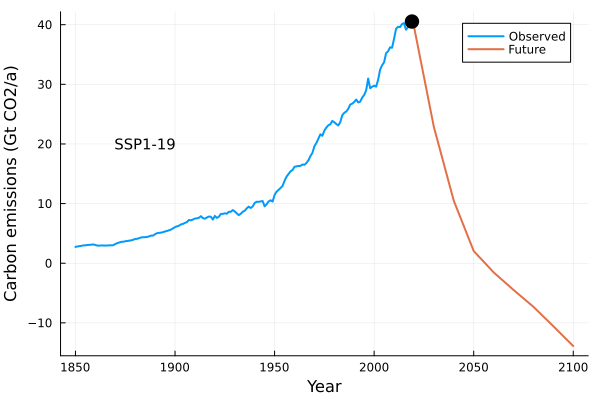

In [5]:
p3=plot(year, Em, linewidth=2, label="Observed")
plot!(year2, FutEm, linewidth=2, label="Future")
scatter!([year[end]], [Em[end]], color=:black, marker=:circle, markersize=8, markerstrokewidth=0, label="")
xlabel!("Year")
ylabel!("Carbon emissions (Gt CO2/a)")
annotate!(1870, 20, text(scenario_txt[scenario + 1], 10, :left))
display(p3)


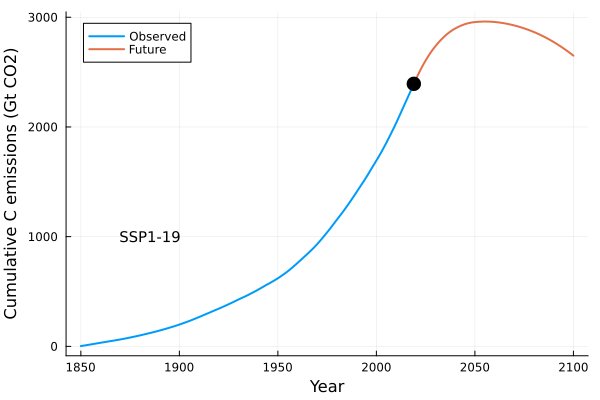

In [6]:
p4=plot(year, Emtot, linewidth=2, label="Observed")
plot!(year2, FutEmtot, linewidth=2, label="Future")
scatter!([year[end]], [Emtot[end]], color=:black, marker=:circle, markersize=8, markerstrokewidth=0, label="")
xlabel!("Year")
ylabel!("Cumulative C emissions (Gt CO2)")
annotate!(1870, 1000, text(scenario_txt[scenario + 1], 10, :left))
display(p4)


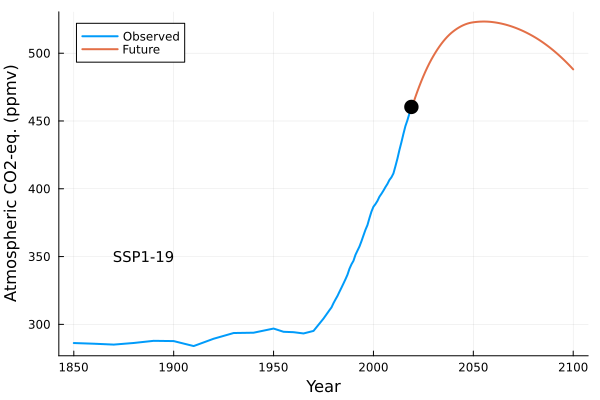

In [7]:
p5=plot(year, CO2, linewidth=2, label="Observed")
plot!(year2, FutCO2, linewidth=2, label="Future")
scatter!([year[end]], [CO2[end]], color=:black, marker=:circle, markersize=8, markerstrokewidth=0, label="")
xlabel!("Year")
ylabel!("Atmospheric CO2-eq. (ppmv)")
annotate!(1870, 350, text(scenario_txt[scenario + 1], 10, :left))
display(p5)

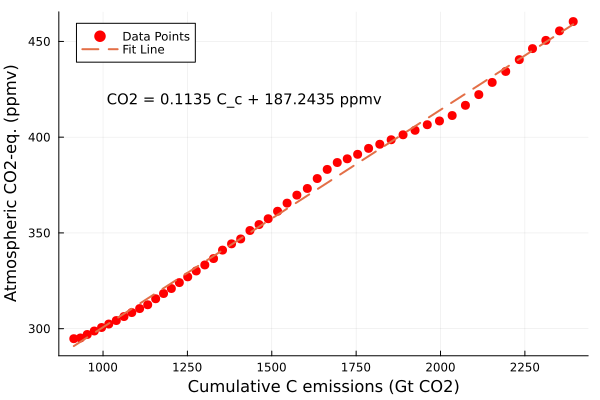

In [8]:
p6 = scatter(Emtot[120:end], CO2[120:end], color=:red, marker=:circle, markersize=5, markerstrokewidth=0, label="Data Points")
plot!(Emtot[120:end], P.(Emtot[120:end]), linestyle=:dash, linewidth=2, label="Fit Line")
txt = @sprintf("CO2 = %.4f C_c + %.4f ppmv", P[1], P[0])
annotate!(Emtot[120] + 100, 420, text(txt, 10, :left))
xlabel!("Cumulative C emissions (Gt CO2)")
ylabel!("Atmospheric CO2-eq. (ppmv)")
display(p6)

# Sea Level Emulator


Pearson correlation coefficient r: 0.932245820969672
T0 = -0.427
a = 2.936
b = -20.58
lambda = -7.01


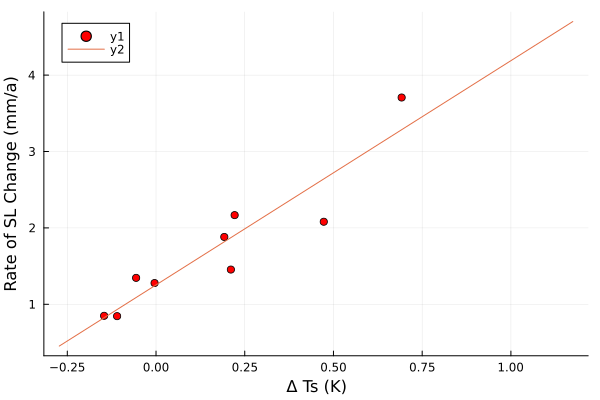

In [10]:
##### ---------------------------------------------
# sea level rise
#---------------------------------------------
# This code produces results of Vermeer and Rahmstorf. 
# "Global Sea Level Linked to Global Temperature", PNAS 2009
# For a description of what it does, see that paper.
#
# Code written by Stefan Rahmstorf and Martin Vermeer
#
# Please note that this is a scientific code to be used by scientists
# who know what they are doing; it is not "fool-proof" for the general 
# user in the sense that all combinations of parameter choices, options etc. 
# have been thoroughly tested.
# Please report any problems or errors to the authors.

#------------------------------
# Parameter and options setting
#------------------------------
# The code uses the SSAtrend of Moore et al. 2005 for smoothing the data,
# which can be downloaded at http://www.glaciology.net/software/ssatrend-m
# (As a simple matlab alternative, fitting a polynomial is available as
# an option below. This is not recommended; it gives only a poor fit, 
# although it has little effect on the future projections.) 
# Reference: J. C. Moore, A. Grinsted, S. Jevrejeva, Eos 86, 226 (2005).

# Data: GMSL dataset at CSIRO:
# https://research.csiro.au/slrwavescoast/sea-level/measurements-and-data/sea-level-data/

# lambda: coefficient for linear combination of T and dT/dt (MV)
# dH/dt = a T + b dT/dt = a (T + lambda dT/dt), so lambda = b/a

function moving_average(data, window_size)
    n = length(data)
    ma = zeros(n)
    for i in 1:n
        if i < window_size
            ma[i] = mean(data[1:i])
        else
            ma[i] = mean(data[i-window_size+1:i])
        end
    end
    return ma
end

function savitzkyGolay(x::Vector, windowSize::Int, polyOrder::Int; deriv::Int=0)

  isodd(windowSize) || throw("Window size must be an odd integer.")
  polyOrder < windowSize || throw("Polynomial order must me less than window size.")

  halfWindow = Int( ceil((windowSize-1)/2) )

  # Setup the S matrix of basis vectors
  S = zeros.(windowSize, polyOrder+1)
  for ct = 0:polyOrder
    S[:,ct+1] = (-halfWindow:halfWindow).^(ct)
  end

  ## Compute the filter coefficients for all orders

  # From the scipy code it seems pinv(S) and taking rows should be enough
  G = S * pinv(S' * S)

  # Slice out the derivative order we want
  filterCoeffs = G[:, deriv+1] * factorial(deriv)

  # Pad the signal with the endpoints and convolve with filter
  paddedX = [x[1]*ones(halfWindow); x; x[end]*ones(halfWindow)]
  y = conv(filterCoeffs[end:-1:1], paddedX)

  # Return the valid midsection
  return y[2*halfWindow+1:end-2*halfWindow]

end


lambda = 0.0

startyearsea = 1880
currentyear = 2020
years = collect(startyearsea:currentyear)

data_gmsl = load_data("CSIRO_Recons_gmsl_yr_2019.txt")

interp_gmsl = LinearInterpolation(data_gmsl[:, 1], data_gmsl[:, 2] .- data_gmsl[1, 2], extrapolation_bc = Line())
SLR = [interp_gmsl(year) for year in years]

data_temps = load_data("BerkeleyTemps.txt")
interp_temps = LinearInterpolation(data_temps[:, 1], data_temps[:, 6], extrapolation_bc = Line())
tmp = [interp_temps(year) for year in years]

tmp = tmp .- mean(tmp[1:70])

# Apply Chao et al (2008) reservoir correction:
if chao == true
    SLR = SLR .+ 1.65 .+ (3.7 / π) .* atan.(years .- 1978, 13)
end

# Apply moving average smoothing
#smoothsealevel = savitzkyGolay(SLR, ed, 3)
#smoothtemp = savitzkyGolay(tmp, ed, 3)
smoothsealevel = moving_average(SLR, ed)
smoothtemp = moving_average(tmp, ed)

rateofrise = diff(smoothsealevel) # time derivative of smoothed sea level
rateoftemp = diff(smoothtemp) # time derivative of smoothed temperature
push!(rateofrise, rateofrise[end])
push!(rateoftemp, rateoftemp[end])

dataspan = 1:floor(Int, (length(SLR) - 1) / bin) # for any binning
mtemp = zeros(Float64, maximum(dataspan))
mtemp2 = zeros(Float64, maximum(dataspan))
mrtmp = zeros(Float64, maximum(dataspan))
mrate = zeros(Float64, maximum(dataspan))
temp = reverse(smoothtemp)
rtmp = reverse(rateoftemp)
rate = reverse(rateofrise)

for i in dataspan
    mtemp[i] = mean(temp[(i-1)*bin+1:i*bin])
    mrtmp[i] = mean(rtmp[(i-1)*bin+1:i*bin])
    mrate[i] = mean(rate[(i-1)*bin+1:i*bin])
end

# Loop for optimal lambda:
rold = 0.0
r = cor(mtemp[dataspan], mrate[dataspan])

while r > rold && la_iterate == true
    global rold = r
    global lambda -= 0.01
    global mtemp2 = mtemp .+ lambda .* mrtmp
    global r = cor(mtemp2[dataspan], mrate[dataspan])
end

if la_iterate == true
    mtemp = mtemp2
end

println("\nPearson correlation coefficient r: ", r)

po = Polynomials.fit(mtemp[dataspan], mrate[dataspan], 1)
fitrate = po.([minimum(tmp) maximum(tmp)])
slope = po[1]
tbase = -po[0] / po[1] # this is the derived pre-industrial base temperature

b = slope * lambda # this is the b parameter
println("T0 = ", round(tbase, digits=3), "\na = ", round(slope, digits=3), "\nb = ", round(b, digits=3), "\nlambda = ", round(lambda, digits=3))

# Compute sea level hindcast from the fit found above 
hindrate = po[0] .+ po[1] .*(smoothtemp .+ lambda .* rateoftemp) # hindcast rate of sea level rise
hindlevel = cumsum(hindrate) # integrate up the rate

# Compute future sea level
fac = 1 / 0.675 # convert herror to s.d.
Futrateoftemp = diff(FutdTs) # time derivative of smoothed temperature
push!(Futrateoftemp, Futrateoftemp[end])
Futrate = po[0] .+ po[1] .*(FutdTs .+ lambda .* Futrateoftemp) # hindcast rate of sea level rise
Futlevel = cumsum(Futrate) .+ hindlevel[end-1] # integrate up the rate

ypred = po.(mtemp[dataspan])
residuals = mrate[dataspan] .- ypred
RSS = sum(residuals.^2)
sigma2 = RSS / (length(mtemp[dataspan]) - 2)
X = [ones(length(mtemp[dataspan])) mtemp[dataspan]]
covmat = inv(X' * X) # should be multiplied by sigma2?
perror = sqrt.(diag(covmat))

predmax = cumsum(Futrate .+ fac .* perror[1]) .+ hindlevel[end-1]
predmin = cumsum(Futrate .- fac .* perror[1]) .+ hindlevel[end-1]

# Compute future sea level with temperature error
FutrateUp = diff(FutdTsUp) # time derivative of smoothed temperature
push!(FutrateUp, FutrateUp[end])
FutUp = po[0] .+ po[1] .*(FutdTsUp .+ lambda .* FutrateUp) # hindcast rate of sea level rise
FutlevelUp = cumsum(FutUp .+ fac .* perror[1]) .+ hindlevel[end-1] # integrate up the rate
FutrateLo = diff(FutdTsLo) # time derivative of smoothed temperature
push!(FutrateLo, FutrateLo[end])
FutLo = po[0] .+ po[1] .*(FutdTsLo .+ lambda .* FutrateLo) # hindcast rate of sea level rise
FutlevelLo = cumsum(FutLo .- fac .* perror[1]) .+ hindlevel[end-1] # integrate up the rate

p7=scatter(mtemp, mrate, marker=:circle, color=:red)
tmpx=reshape([minimum(tmp), maximum(tmp)],2,1)
plot!(tmpx, fitrate')
ylabel!("Rate of SL Change (mm/a)")
xlabel!("Δ Ts (K)")
display(p7)

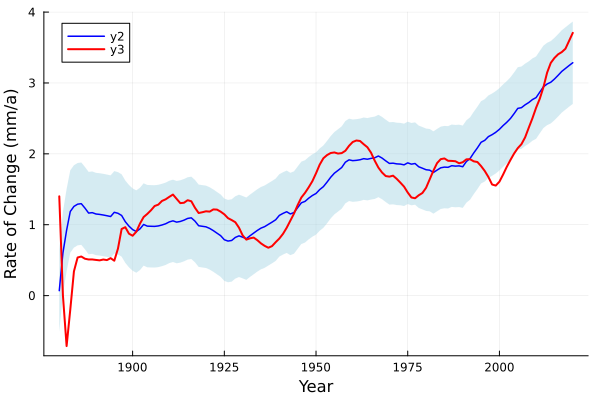

In [11]:
xh = vcat(years, reverse(years))
hindrate = moving_average(hindrate, ed)
yh = vcat((hindrate .+ fac .* perror[1]), reverse((hindrate .- fac .* perror[1])))
p8=plot(xh, yh, fillrange=0, fillcolor=:lightblue, fillalpha=0.5, linecolor=:transparent, linewidth=0,label="")
smoothrate = moving_average(rateofrise, ed)
plot!(years, hindrate, color=:blue, linewidth=1.5)
plot!(years, smoothrate, color=:red, linewidth=2)
ylabel!("Rate of Change (mm/a)")
xlabel!("Year")
display(p8)

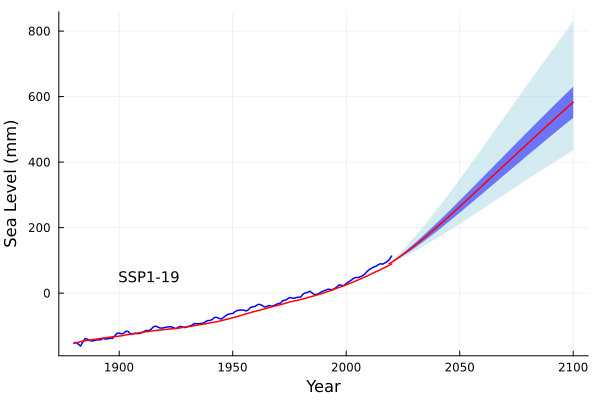

In [12]:
SLR0 = hindlevel[findfirst(years .== 1990)]
xs = vcat(year2, reverse(year2))
ys = vcat(FutlevelUp, reverse(FutlevelLo))
p9=plot(xs, ys .- SLR0, fillrange=0, fillcolor=:lightblue, fillalpha=0.5, linecolor=:transparent, linewidth=0,label="")
xs = vcat(year2, reverse(year2))
ys = vcat(predmax, reverse(predmin))
plot!(xs, ys .- SLR0, fillrange=0, fillcolor=:blue, fillalpha=0.5, linecolor=:transparent, linewidth=0,label="")
plot!(years, SLR .- SLR0, color=:blue, linewidth=1.5,label="")
plot!(years, hindlevel .- SLR0, color=:red, linewidth=1.5,label="")
plot!(year2, Futlevel .- SLR0, color=:red, linewidth=1.5,label="")
ylabel!("Sea Level (mm)")
xlabel!("Year")
annotate!(1900, 50, text(scenario_txt[scenario + 1], 10, :left))
display(p9)
